In [9]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from joblib import load
from datetime import datetime

In [10]:
SEED = 42
EPOCHS = 15
BATCH  = 32

tf.keras.utils.set_random_seed(SEED)

In [11]:
ARTIFACTS_DIR = "../artifacts"
MODEL_NAME = "cnn_pooling"

INPUT_FILE = os.path.join(ARTIFACTS_DIR, "images_tuple.joblib")

LOG_DIR   = os.path.join(ARTIFACTS_DIR, "logs", f"{MODEL_NAME}")
MODEL_FILE = os.path.join(ARTIFACTS_DIR, f"{MODEL_NAME}.keras")
CKPT_FILE  = os.path.join(ARTIFACTS_DIR, f"best_{MODEL_NAME}.keras")

In [12]:
(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    classes
) = load(INPUT_FILE)

num_classes = len(classes)
print("Classes:", classes)
print("Train shape:", X_train.shape, y_train.shape)

Classes: ['az', 'dobro', 'estb', 'frbtb', 'ize', 'jatb', 'ljudie', 'nasb', 'sa', 'sta', 'ukb', 'vede']
Train shape: (900, 128, 128, 4) (900, 12)


In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.Rescaling(1.0 / 255),
    
    tf.keras.layers.Conv2D(32, (3,3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 64, 64, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │       984,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 985,676 (3.76 MB)

 Trainable params: 985,676 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        CKPT_FILE, monitor="val_categorical_accuracy", save_best_only=True
    )
]

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/15


2025-10-23 22:41:39.491977: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 235929600 exceeds 10% of free system memory.


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.2259 - loss: 2.2814

2025-10-23 22:41:41.616048: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67633152 exceeds 10% of free system memory.


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - categorical_accuracy: 0.2309 - loss: 2.2689 - val_categorical_accuracy: 0.6977 - val_loss: 1.0855
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - categorical_accuracy: 0.7475 - loss: 0.8215 - val_categorical_accuracy: 0.8295 - val_loss: 0.5694
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - categorical_accuracy: 0.8984 - loss: 0.3683 - val_categorical_accuracy: 0.8721 - val_loss: 0.4033
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - categorical_accuracy: 0.9577 - loss: 0.1744 - val_categorical_accuracy: 0.8915 - val_loss: 0.3429
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - categorical_accuracy: 0.9793 - loss: 0.1010 - val_categorical_accuracy: 0.9070 - val_loss: 0.3060
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - categorical_accuracy: 0.9909 - loss: 0.0693 - val_categorical_accuracy: 0.9147 - val_loss: 0.3119
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - categorical_accuracy: 0.9967 - loss: 0.0444 - val_ca

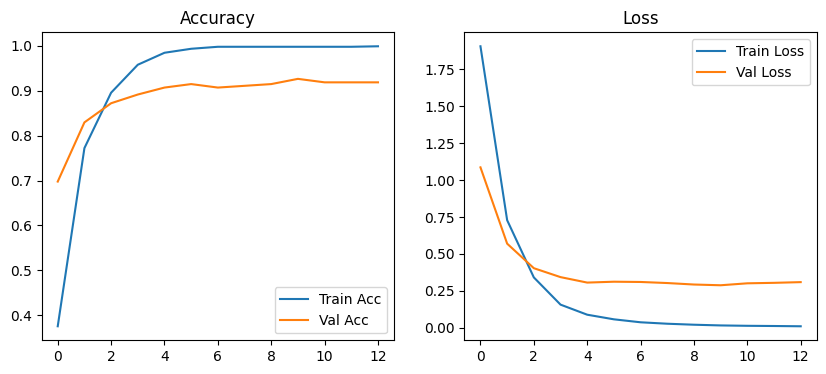

In [15]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['categorical_accuracy'], label='Train Acc')
plt.plot(history.history['val_categorical_accuracy'], label='Val Acc')
plt.title('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss'); plt.legend()

plt.show()

In [16]:
model.save(MODEL_FILE)
print(f"Saved model to {MODEL_FILE}")

Saved model to ../artifacts/cnn_pooling.keras
